# Simple aperture photometry

* stack a few raw images
* subtract median
* find peaks and sort
* get n brightest peaks
* save centroid location (smaller box)
* crop image location and get new peak locations
* do photometry
* measure background
* measure fwhm

## References

* HAT-P-14 b [(Fukui+16a))](http://iopscience.iop.org/article/10.3847/0004-637X/819/1/27/pdf)
* K2-3d [(Fukui+16b)](http://iopscience.iop.org/article/10.3847/0004-6256/152/6/171) 

In [1]:
!python --version

Python 3.6.1 :: Continuum Analytics, Inc.


In [2]:
import os
os.environ['CONDA_DEFAULT_ENV']

'moscatel'

In [3]:
import os
from glob import glob
import getpass
from tqdm import tqdm
import warnings

filedir='/home/'+getpass.getuser()+'/data/transit/hatp44_data'
file_list = glob(os.path.join(filedir,'*.fits'))
file_list.sort()
len(file_list)

1456

In [4]:
from moscatel import utils

bands = utils.get_band_list(file_list);

100%|██████████| 1456/1456 [00:04<00:00, 326.28it/s]

g-band: 376 frames
r-band: 704 frames
z_s-band: 376 frames


In [5]:
bands.keys()

dict_keys(['g', 'r', 'z_s'])

In [6]:
sorted(bands.keys())

['g', 'r', 'z_s']

## Stack (some) raw images

In [9]:
from moscatel import utils

stacked_images = []
for key in sorted(bands.keys()):
    stacked_images.append(utils.stack_raw_images(bands[key], skip_every=10))

  2%|▏         | 14/704 [00:00<00:04, 139.17it/s]

number of stacked raw images=376


  4%|▍         | 15/376 [00:00<00:02, 145.45it/s]

number of stacked raw images=704


100%|██████████| 376/376 [00:03<00:00, 103.91it/s]


number of stacked raw images=376


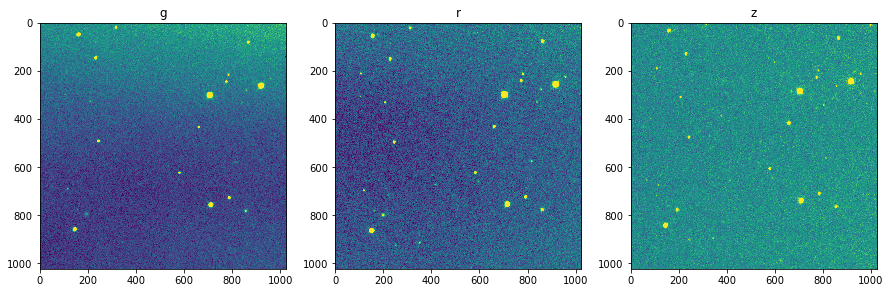

In [10]:
from moscatel import utils
%matplotlib inline

utils.show_stacked_images(stacked_images)

## Detect point sources

In [11]:
from moscatel import phot

sources = []

for idx, img in enumerate(stacked_images):
    sources.append(phot.get_sources(img, num_stars=10))

In [12]:
len(sources) #g,r,z_s

3

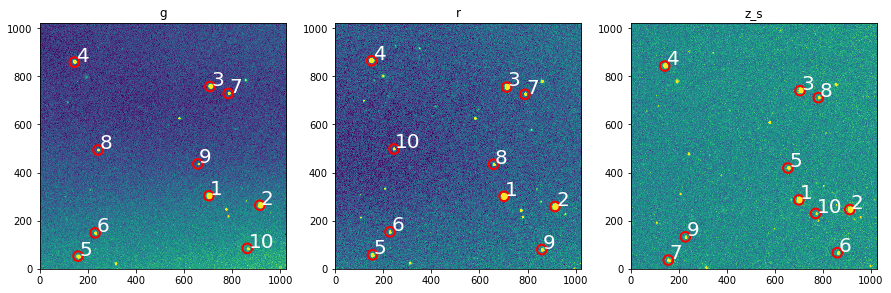

In [13]:
from moscatel import plotting

plotting.show_sources(stacked_images, sources, sorted(bands.keys()), num_stars=10)

note that star 1 and 2 is different in g-band.

## check centroids per band

In [14]:
idx=2; #0:g, 1:r, 2:z_s

centroids_z = list(zip(sources[idx]['xcentroid'],sources[idx]['ycentroid']))
centroids_z

[(699.57022728837183, 285.99607368257477),
 (911.39859728804333, 246.04366816591983),
 (704.22007897925596, 740.51054978181958),
 (141.85914542502209, 842.85719395591639),
 (653.89390192371843, 418.55984497878495),
 (859.41669909244115, 66.262842865601158),
 (156.39027449611459, 35.841334970873348),
 (780.59287023401725, 711.58040245973143),
 (227.56652342925844, 132.56169253707972),
 (769.14635586713632, 229.71906863347894)]

there is problem in stars detection near edges

## check if such centroids coincide for all stars in one sample image

sample image

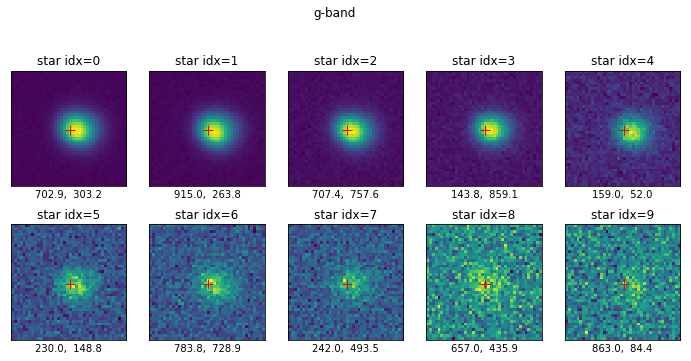

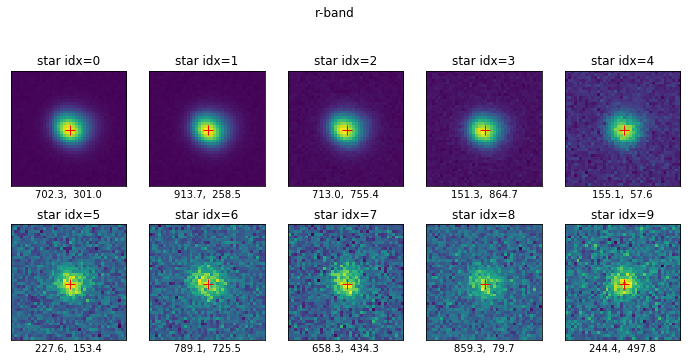

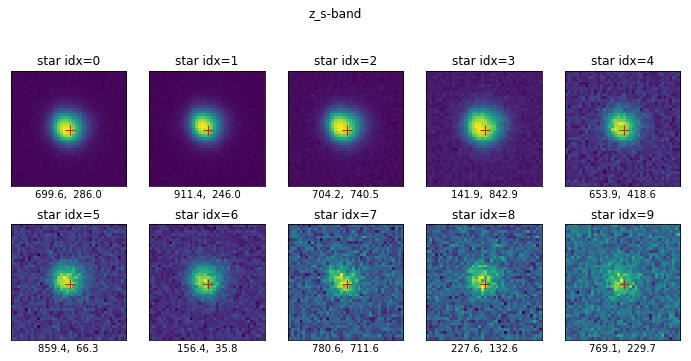

In [15]:
from moscatel import plotting

try:
    from astropy.io import fits as pf
except:
    import pyfits as pf
import matplotlib.pyplot as plt

star_id = 0 #first, brightest
nstars = 10 #num of stars in one image

keys = sorted(bands.keys()) #'g,r,z_s'.split(',') #bands.keys() are not sorted!

centroids_g = list(zip(sources[0]['xcentroid'],sources[0]['ycentroid']))
centroids_r = list(zip(sources[1]['xcentroid'],sources[1]['ycentroid']))
centroids_z = list(zip(sources[2]['xcentroid'],sources[2]['ycentroid']))
centroids = [centroids_g,centroids_r,centroids_z]
   
for band_id, (key,centroid)  in enumerate(list(zip(keys, centroids))):
    #use first image always
    sample_img = pf.getdata(bands[key][star_id]) 
    plotting.show_one_image_all_centroid(sample_img, centroid, key, nstars=10, figsize=(12,8))

## check if one centroid $n$ coincide with (all) images in each band

try changing `skip_every`

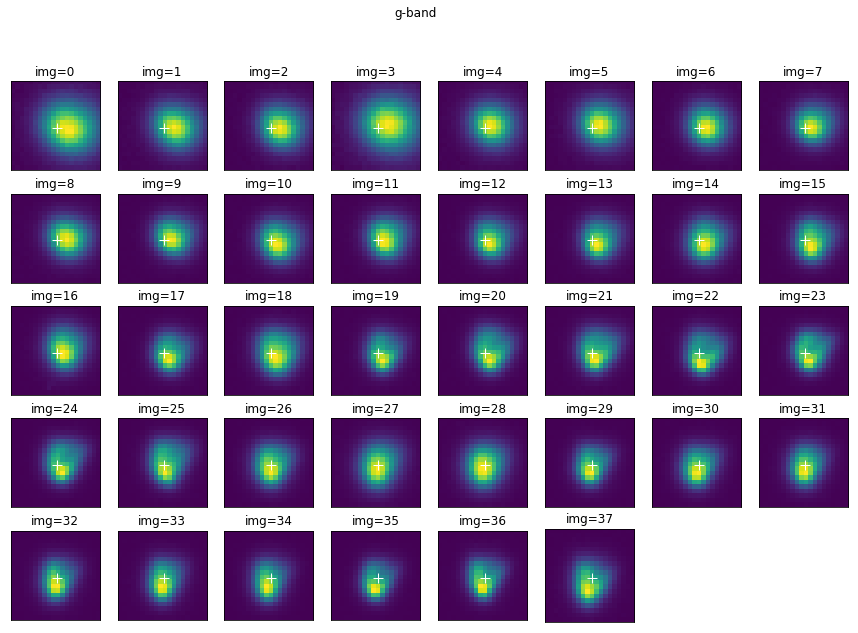

In [16]:
skip_every=10

num=0
centroids_g = list(zip(sources[num]['xcentroid'],sources[num]['ycentroid']))
band = bands['g']
centroid = centroids_g[0]
  
plotting.show_one_centroid_all_image(band, centroid, skip_every, boxsize=20, ncols=8, figsize=(15,10))

/home/Jerome/github/moscatel/notebook/moscatel/plotting.py:109: UserWarning: star not cropped
  warnings.warn('star not cropped')


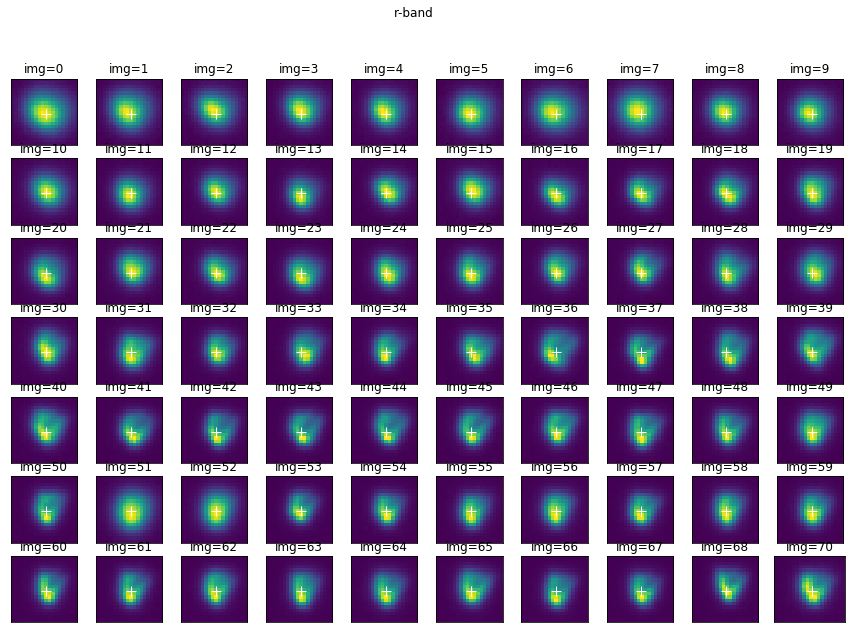

In [17]:
skip_every=10
num=1
band = bands['r']
centroid = centroids_r[0]
  
plotting.show_one_centroid_all_image(band, centroid, skip_every, boxsize=20, ncols=10, figsize=(15,10))

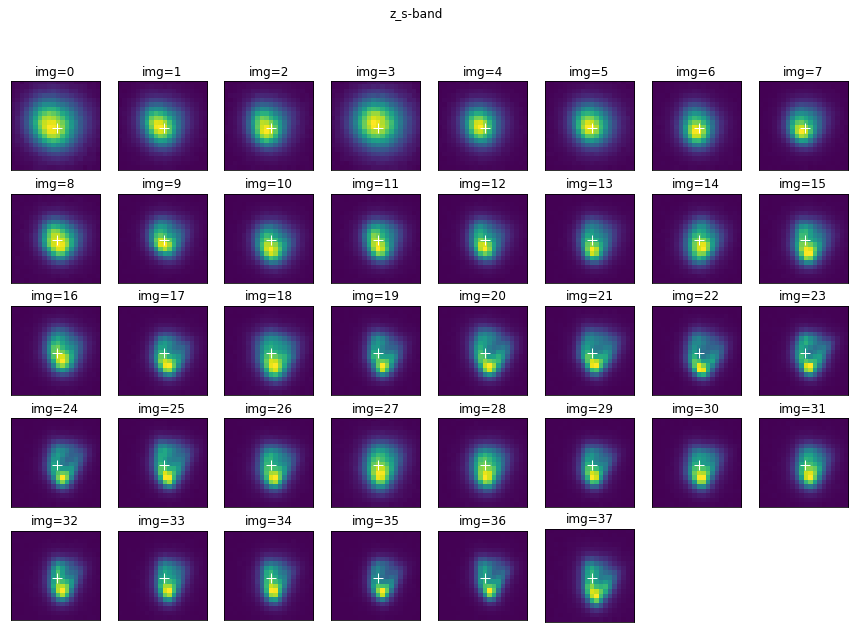

In [18]:
skip_every=10
num=2
band = bands['z_s']
centroid = centroids_z[0]
  
plotting.show_one_centroid_all_image(band, centroid, skip_every, boxsize=20, ncols=8, figsize=(15,10))

## aperture photometry

[`photutils.aperture`](http://photutils.readthedocs.io/en/latest/photutils/aperture.html)


for masking, [see](http://stackoverflow.com/questions/8647024/how-to-apply-a-disc-shaped-mask-to-a-numpy-array)


try `aperture_photometry( ... ,method='subpixel', subpixels=5)` for subpixel accucacy.

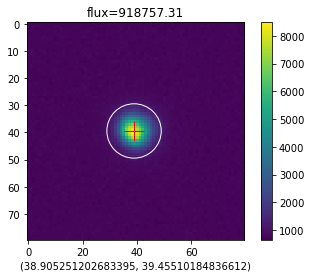

In [19]:
from photutils import CircularAperture
from photutils import aperture_photometry
import numpy as np

sample_img = pf.open(bands['z_s'][0])[0].data
centroid = centroids_z[0]
boxsize=80
#crop
img_crop=utils.get_crop(sample_img,centroid,box_size=boxsize)
recentroid = phot.get_centroid(img_crop, method='2D_gaussian')
#photometry
aperture = CircularAperture(recentroid, r=10) 
result = aperture_photometry(img_crop, aperture) #,method='subpixel', subpixels=5)
flux = float(result['aperture_sum'])#/aperture.area())

plt.imshow(img_crop)
plt.xlabel(recentroid)
plt.title('flux={:.2f}'.format(flux))
plt.colorbar()
plt.plot(recentroid[0],recentroid[1],'+', c='r', ms=20, lw=10)
aperture.plot(color='w')

## global background

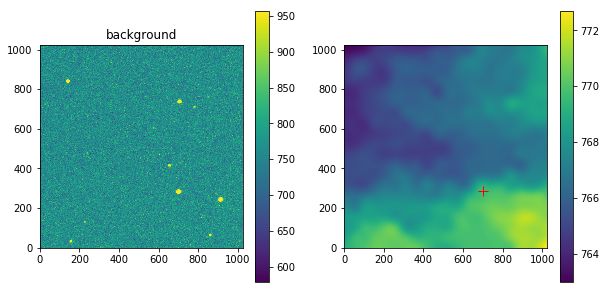

In [20]:
try:
    from astropy.io import fits as pf
except:
    import pyfits as pf
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
from photutils import Background2D, SigmaClip, MedianBackground

sample_img = pf.open(bands['z_s'][0])[0].data

sigma_clip = SigmaClip(sigma=3., iters=10)
bkg_estimator = MedianBackground()
bkg = Background2D(sample_img, (50, 50), filter_size=(3, 3),
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

vmin,vmax= ZScaleInterval().get_limits(sample_img)

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax1 = ax[0].imshow(sample_img, origin='lower',vmin=vmin,vmax=vmax)
ax[0].set_title('sample image')
fig.colorbar(ax1, ax=ax[0])
ax2 = ax[1].imshow(bkg.background, origin='lower')
ax[1].plot(centroid[0], centroid[1], 'r+', markersize=10)
ax[0].set_title('background')
fig.colorbar(ax2, ax=ax[1])

local background level at star 1

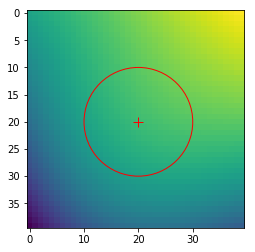

In [21]:
xcen,ycen = int(centroid[0]),int(centroid[1])
n=20
plt.imshow(bkg.background[ycen-n:ycen+n,xcen-n:xcen+n])
plt.plot(20, 20, 'r+', markersize=10)
CircularAperture((20, 20),r=10).plot(color='r')

#plt.plot(centroid[0], centroid[1], 'r+', markersize=10)

## estimate and subtract local sky background

bkg_mean=835.0091533177217


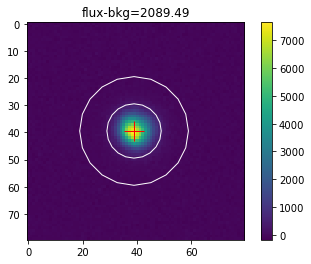

In [22]:
from photutils import CircularAnnulus

#photometry
aperture = CircularAperture(recentroid, r=10) 
phot_result = aperture_photometry(img_crop, aperture)
flux = float(phot_result['aperture_sum']/aperture.area())

annulus = CircularAnnulus(recentroid, r_in=10., r_out=20.)
ann_result = aperture_photometry(img_crop, annulus)
bkg = float(ann_result['aperture_sum'])
bkg_mean = bkg / annulus.area()

res=flux-bkg_mean
plt.imshow(img_crop-bkg_mean)
plt.title('flux-bkg={:.2f}'.format(res))
plt.colorbar()
plt.plot(recentroid[0],recentroid[1],'+', c='r', ms=20, lw=10)
annulus.plot(color='w')

print('bkg_mean={}'.format(bkg_mean))

## compute uncertainty; std within annulus

In [23]:
phot.get_uncertainty(img_crop, r_in=15, r_out=20, mode='std')

31.349443

## compute peak flux within aperture

In [24]:
phot.get_peak_flux(img_crop, r_in=15, r_out=20)

880.43359

## count as a function of r (multiple apertures)

## 1D psf modeling

In [25]:
try:
    from astropy.io import fits as pf
except:
    import pyfits as pf
from astropy.visualization import ZScaleInterval
from astropy.stats import sigma_clipped_stats
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

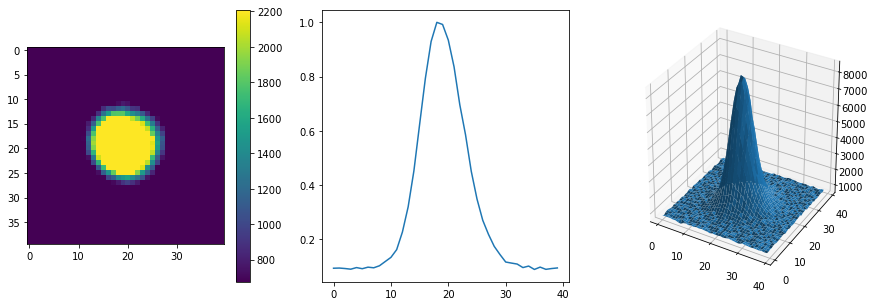

In [26]:
from moscatel import plotting

sample_img = pf.open(bands['z_s'][0])[0].data
img_crop=utils.get_crop(sample_img,centroids_z[0],box_size=40)

plotting.plot_psf(img_crop)

In [27]:
from moscatel import utils

fwhm_estimate = 10 #pix

sigma_estimate = utils.fwhm_to_sigma(fwhm_estimate)
sigma_estimate

4.2466090014400955

A: 0.9001169022951652
mu: 19.196072687157997
sigma= 3.742165618601782
eps: 0.09586311139612155


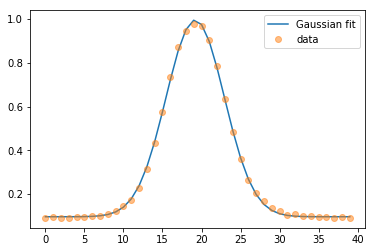

In [28]:
from moscatel import models

sample_img = pf.open(bands['z_s'][0])[0].data
img_crop=utils.get_crop(sample_img,centroids_z[0],box_size=40)

fit_result = models.model_gaussian(img_crop,verbose=True,show_fit=True);

In [29]:
utils.sigma_to_fwhm(fit_result[2])

8.8121266105091198

with convolution

A: 0.817232744808113
mu: 19.220236639953573
sigma= 5.564521864703894
eps: 0.1820800011977746


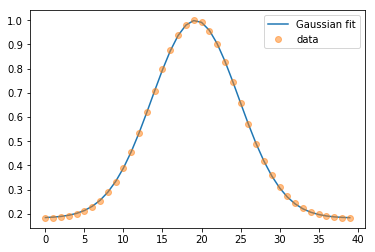

In [30]:
fit_result = models.model_gaussian(img_crop,convolve=True,verbose=True,show_fit=True);

In [31]:
utils.sigma_to_fwhm(fit_result[2])

13.103447628017726

In [32]:
models.get_fwhm(img_crop)

8.8121266105091198

4.04105924272
4.00247638446
3.96321175685
3.82506934781
0.0919117629528
0.0414096191525
0.0364862978458
0.0284731145948
0.0173205062747
0.015594150871


/home/Jerome/miniconda3/envs/moscatel/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


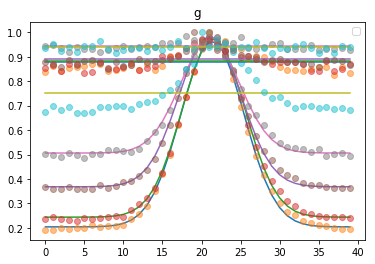

In [33]:
from moscatel import models

#check sigma of all stars in gband
band='g'
sample_img = pf.getdata(bands[band][0])

for i,xy in enumerate(centroids_g[:10]):
    #bkg subtraction?
    try:
        img_crop = utils.get_crop(sample_img, xy, box_size=40)
        fit_result = models.model_gaussian(img_crop,show_fit=True)
        print(fit_result[2]) #sigma
    except:
        warnings.warn('no good fit')
plt.title('{}'.format(band))
plt.legend([])

3.80498684774
3.75039031089
3.84623105785
3.83569133917
0.110014073551
0.0539399124682
0.0461960397661
0.0435239337385
0.0417395606637
0.0366695709527


/home/Jerome/miniconda3/envs/moscatel/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


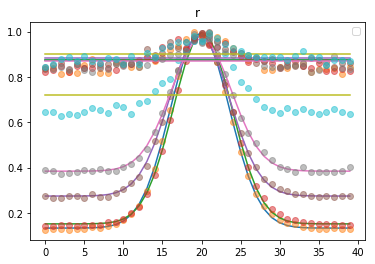

In [34]:
#check sigma of all stars in rband
band='r'
sample_img = pf.getdata(bands[band][0])

for i,xy in enumerate(centroids_r[:10]):
    #bkg subtraction?
    try:
        img_crop = utils.get_crop(sample_img, xy, box_size=40)
        fit_result = models.model_gaussian(img_crop,show_fit=True)
        print(fit_result[2]) #sigma
    except:
        warnings.warn('no good fit')
plt.title('{}'.format(band))
plt.legend([])

1D gaussian modeling is good only up to 4th brightest star

## check sigma of many stars in one sample image of each band

try `recenter = True` and other centroiding `methods=2D_gaussian,1D_gaussian,com`

/home/Jerome/miniconda3/envs/moscatel/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/Jerome/miniconda3/envs/moscatel/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: 
star not cropped



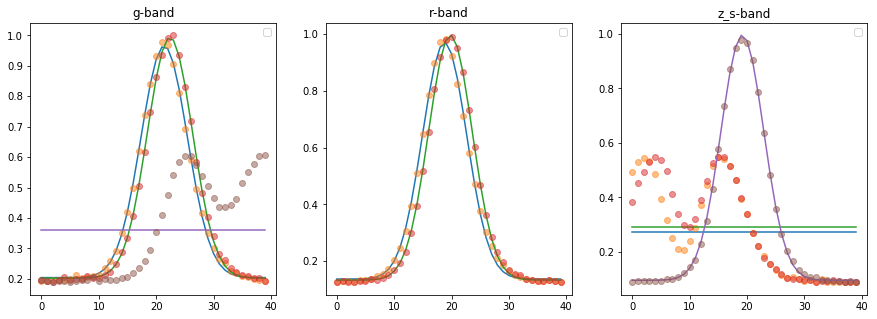

In [35]:
#check sigma of 5 stars in one image of each band
recenter = False

nstars=5
img_num = 0 #use first sample image
boxsize = 40

centroids = [centroids_g[0],centroids_r[0],centroids_z[0]]
sigmas = {}
keys = sorted(bands.keys())

fig = plt.figure(figsize=(15,5))

for idx, (key, centroid) in enumerate(list(zip(keys,centroids))):
    sigmas[key] = []
    #loop at different (ref) stars
    for xy in centroids[:nstars]:
        img=pf.getdata(bands[key][img_num])
        ax = plt.subplot(1,len(bands.keys()),idx+1)
        try:
            if recenter == True:
                #crop a bigger box first
                img_crop = utils.get_crop(img, xy, box_size=80)
                #############RECENTROID#############
                xy_new = phot.get_centroid(img_crop, method='2D_gaussian')

                #------------RE-CROP with smaller box------------#
                img_crop = utils.get_crop(img_crop, xy_new, box_size=boxsize)
            else:
                img_crop = utils.get_crop(img, xy, box_size=boxsize)
            fit_result = models.model_gaussian(img_crop, show_fit=True)
            sigmas[key].append(fit_result[2])

        except:
            warnings.warn('\nstar not cropped\n')
    plt.legend([])
    plt.title('{}-band'.format(key))

some non-gaussian and hence results in bad fit 

## Try convolving the faint (ref) stars

/home/Jerome/miniconda3/envs/moscatel/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: star not cropped
/home/Jerome/miniconda3/envs/moscatel/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


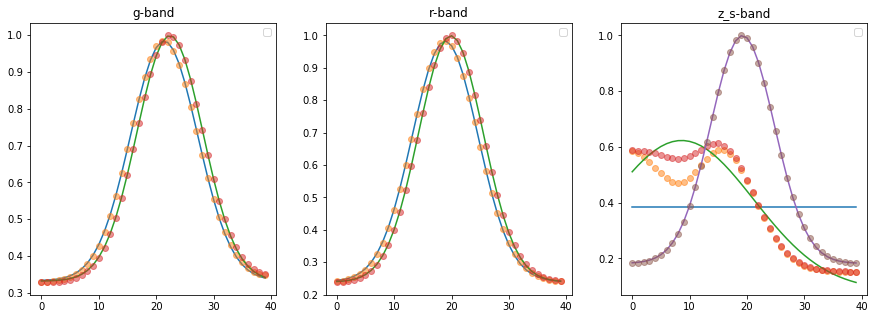

In [36]:
#check sigma of 5 stars in one image of each band
recenter = False

nstars=5
img_num = 0 #use first sample image
boxsize = 40

centroids = [centroids_g[0],centroids_r[0],centroids_z[0]]
sigmas = {}
keys = sorted(bands.keys())

fig = plt.figure(figsize=(15,5))

for idx, (key, centroid) in enumerate(list(zip(keys,centroids))):
    sigmas[key] = []
    #loop at different (ref) stars
    for xy in centroids[:nstars]:
        img=pf.getdata(bands[key][img_num])
        ax = plt.subplot(1,len(bands.keys()),idx+1)
        try:
            if recenter == True:
                #crop a bigger box first
                img_crop = utils.get_crop(img, xy, box_size=80)
                #############RECENTROID#############
                xy_new = phot.get_centroid(img_crop, method='2D_gaussian')

                #------------RE-CROP with smaller box------------#
                img_crop = utils.get_crop(img_crop, xy_new, box_size=boxsize)
            else:
                img_crop = utils.get_crop(img, xy, box_size=boxsize)
            fit_result = models.model_gaussian(img_crop, show_fit=True, convolve=True)
            sigmas[key].append(fit_result[2]) #sigma

        except:
            warnings.warn('star not cropped')
    plt.legend([])
    plt.title('{}-band'.format(key))

## check sigma of one star in $n$ number of images in each band (try convolving too)

try `recenter = True`, `convolve=True` and other centroiding `methods=2D_gaussian,1D_gaussian,com`

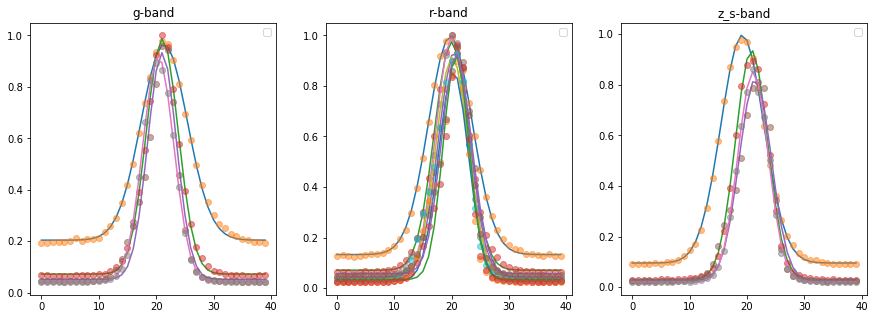

In [37]:
#check sigma of one star in many images each band
recenter = False

skip_every=100
star_id = 0 #first,brightest
centers = [centroids_g[star_id],centroids_r[star_id],centroids_z[star_id]]
boxsize = 40
sigmas = {}
fwhms = {}
keys = sorted(bands.keys())

fig = plt.figure(figsize=(15,5))

for idx,(key,centroid) in enumerate(list(zip(keys,centers))):
    sigmas[key] = []
    fwhms[key] = []
    for i in bands[key][::skip_every]:
        img=pf.getdata(i)
        plt.subplot(1,3,idx+1)
        try:
            if recenter == True:
                #crop a bigger box first
                img_crop = utils.get_crop(img, xy, box_size=80)
                #############RECENTROID#############
                xy_new = phot.get_centroid(img_crop, method='2D_gaussian')

                #------------RE-CROP with smaller box------------#
                img_crop = utils.get_crop(img_crop, xy_new, box_size=boxsize)
            else:
                img_crop = utils.get_crop(img, centroid, box_size=boxsize)
            fit_result = models.model_gaussian(img_crop, show_fit=True)#, convolve=True)
            sigmas[key].append(fit_result[2]) #sigma
            fwhms[key].append(utils.sigma_to_fwhm(fit_result[2])) #sigma

        except:
            warnings.warn('star not cropped')
    plt.legend([])
    plt.title('{}-band'.format(key))

fwhm estimation works for the (first) brightest star in all images in each band

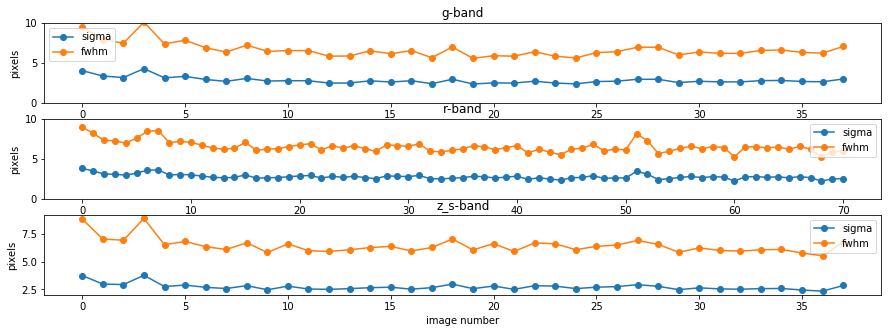

In [38]:
#check sigma of one star in many images each band
recenter = False

skip_every=10
star_id = 0 #first,brightest
centers = [centroids_g[star_id],centroids_r[star_id],centroids_z[star_id]]
boxsize = 40
sigmas = {}
fwhms = {}
keys = sorted(bands.keys())

for idx,(key,centroid) in enumerate(list(zip(keys,centers))):
    sigmas[key] = []
    fwhms[key] = []
    for i in bands[key][::skip_every]:
        img=pf.getdata(i)
        try:
            if recenter == True:
                #crop a bigger box first
                img_crop = utils.get_crop(img, xy, box_size=80)
                #############RECENTROID#############
                xy_new = phot.get_centroid(img_crop, method='2D_gaussian')

                #------------RE-CROP with smaller box------------#
                img_crop = utils.get_crop(img_crop, xy_new, box_size=boxsize)
            else:
                img_crop = utils.get_crop(img, centroid, box_size=boxsize)
            fit_result = models.model_gaussian(img_crop)#, show_fit=True)#, convolve=True)
            sigmas[key].append(fit_result[2]) #sigma
            fwhms[key].append(utils.sigma_to_fwhm(fit_result[2])) #sigma

        except:
            warnings.warn('star not cropped')

#plot
fig = plt.figure(figsize=(15,5))

for idx, key in enumerate(sorted(sigmas.keys())):
    ax=plt.subplot(3,1,idx+1)
    ax.plot(sigmas[key], 'o-', label='sigma')
    ax.plot(np.array(fwhms[key]), 'o-',label='fwhm')
    ax.set_title('{}-band'.format(key))
    ax.set_xlabel('image number')
    ax.set_ylabel('pixels')
    ax.set_ylim([0,10])
    ax.legend()
plt.axis('tight');

## 2D psf modeling

### 2D Gaussian


Try `recenter=True`, `convolve=True` 

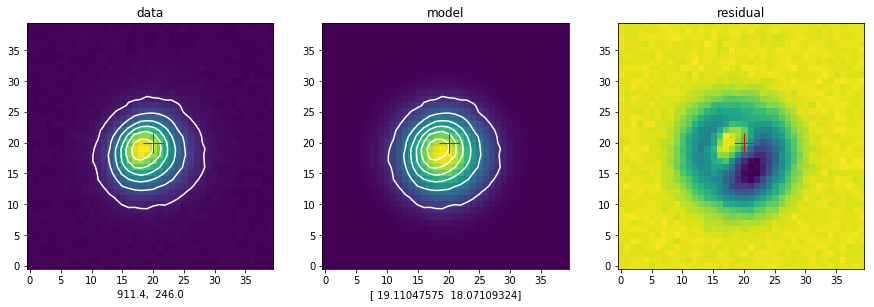

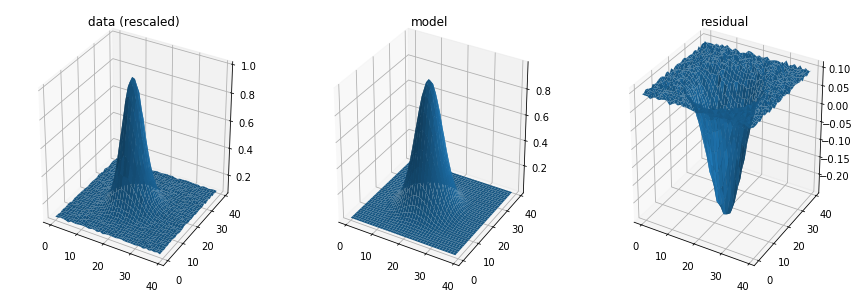

In [39]:
import matplotlib.pyplot as plt

star_id= 1 #brightest star in img_id
img_id = 0 #first image
boxsize = 40
band = 'z_s' #depends on centroids_z below
sample_img = pf.open(bands[band][img_id])[0].data
centroid = centroids_z[star_id]

g=plotting.show_fit_2D(sample_img, centroid, show_image=True, show_3D=True, 
                     convolve=False, sigma_estimate=4, boxsize=40, recenter=False);

In [40]:
g.param_sets

array([[  9.84914472e-01],
       [  1.91104758e+01],
       [  1.80710932e+01],
       [  4.47673623e+00],
       [  4.43817717e+00],
       [  3.62874306e-03]])

with recentroiding & convolution

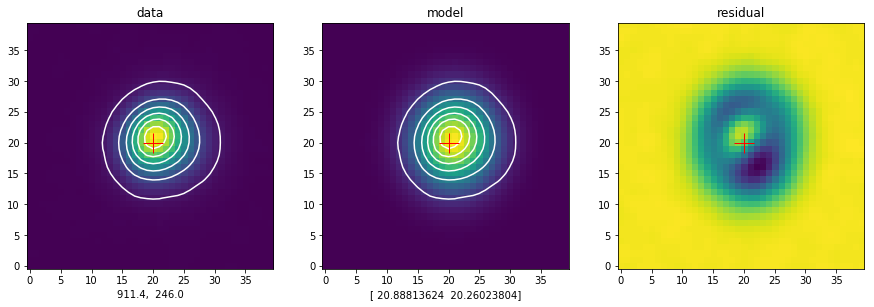

In [41]:
import matplotlib.pyplot as plt

star_id= 1 #brightest star in img_id
img_id = 0 #first image
boxsize = 40
band = 'z_s' #depends on centroids_z below
sample_img = pf.open(bands[band][img_id])[0].data
centroid = centroids_z[star_id]

g=plotting.show_fit_2D(sample_img, centroid, show_image=True, show_3D=False, 
                     convolve=True, sigma_estimate=1, boxsize=40, recenter=True);

recentroiding sometimes produces worse model and higher residual if convolution is too much (fwhm>>4)

In [42]:
from moscatel import models

#check sigma of one star in all gband images
skip_every=10
centers = [centroids_g[0],centroids_r[0],centroids_z[0]]
#band_names = 'g r z'.split(' ')
sigmas_2Dx = {}
sigmas_2Dy = {}

for idx,(key,centroid) in enumerate(list(zip(sorted(bands.keys()),centers))):
    sigmas_2Dx[key], sigmas_2Dy[key] = [], []
    for i in bands[key][::skip_every]:
        img=pf.getdata(i)
        try:
            img_crop = utils.get_crop(img, centroid, box_size=60)
            g = models.model_gaussian2D(img_crop)
            sigmas_2Dx[key].append(g.x_stddev.value)
            sigmas_2Dy[key].append(g.y_stddev.value)

        except:
            warnings.warn('star not cropped')

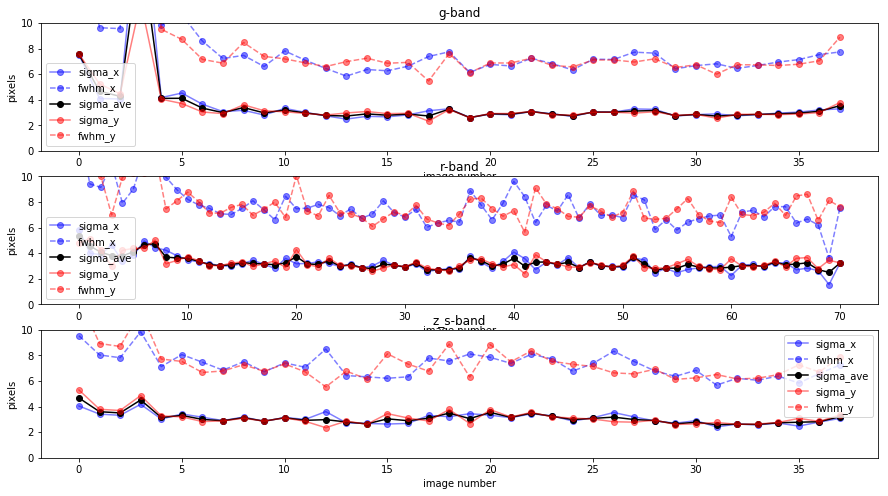

In [43]:
fig = plt.figure(figsize=(15,8))

for idx, key in enumerate(sorted(sigmas_2Dx.keys())):
    ax=plt.subplot(3,1,idx+1)
    ax.plot(sigmas_2Dx[key], 'bo-', label='sigma_x',alpha=0.5)
    ax.plot(np.array(sigmas_2Dx[key])*2.355, 'bo--',label='fwhm_x',alpha=0.5)
    sigma_ave=(np.array(sigmas_2Dx[key])+np.array(sigmas_2Dy[key]))/2
    ax.plot(sigma_ave, 'ko-', label='sigma_ave')
    ax.plot(sigmas_2Dy[key], 'ro-', label='sigma_y',alpha=0.5)
    #also use sigma_to_fwhm()
    ax.plot(np.array(sigmas_2Dy[key])*2.355, 'ro--',label='fwhm_y',alpha=0.5)
    ax.set_title('{}-band'.format(key))
    ax.set_xlabel('image number')
    ax.set_ylim([0,10])
    ax.set_ylabel('pixels')
    ax.legend()
    

2D fit sometimes becomes unstable

## radial profile

/home/Jerome/miniconda3/envs/moscatel/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


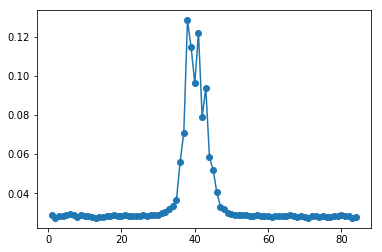

In [44]:
import numpy as np

def radial_profile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)

    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile 

rad_prof=radial_profile(img_crop, (img_crop.shape[0],img_crop.shape[1]))
plt.plot(rad_prof,'o-')

alternatively, fit a model to the radial profile above; might not correctly give the sigma/fwhm though

### Moffat

## create time series

## try for g-band with 3 stars and 2 aperture radii

In [45]:
from moscatel import phot

centroids_g = list(zip(sources[0]['xcentroid'],sources[0]['ycentroid']))
centroids_r = list(zip(sources[1]['xcentroid'],sources[1]['ycentroid']))
centroids_z = list(zip(sources[2]['xcentroid'],sources[2]['ycentroid']))
centroids = [centroids_g,centroids_r,centroids_z]

band_idx = 0 #g,r,z
nstars=3 # or specify as centroids[band_idx][idx0,idx1,...]
skip_every=1
radii =[10,11]
box_size = 40

tables=phot.make_lightcurve(bands['g'], centroids[band_idx][:nstars], 
                       aperture_radii=radii, skip_every=1, box_size=40, 
                       r_in=15, r_out=20);

  1%|          | 2/376 [00:00<00:36, 10.37it/s]

performing aperture photometry on 3 stars


---------star index: 0---------
initial centroid: (702.89569058915913, 303.24546019686505)


  1%|          | 2/376 [00:00<00:34, 10.97it/s]


---------star index: 1---------
initial centroid: (914.98331267516869, 263.79361382872224)


  1%|          | 2/376 [00:00<00:34, 10.95it/s]


---------star index: 2---------
initial centroid: (707.44722065048688, 757.64144041910174)


100%|██████████| 376/376 [00:43<00:00,  7.87it/s]

---------Done---------


In [46]:
#table per star
tables.keys()

dict_keys([0, 1, 2])

In [47]:
#choose star 0
#showing table per time
len(tables[0])

376

In [48]:
#star 0 at time 0
tables[0][0].columns

TableColumns([('id', <Column name='id' dtype='int64' length=1>
               1), ('xcenter', <Column name='xcenter' dtype='float64' length=1>
               705.464728148), ('ycenter',
               <Column name='ycenter' dtype='float64' length=1>
               303.356412189), ('aperture_sum_0',
               <Column name='aperture_sum_0' dtype='float64' length=1>
               1843783.05086), ('aperture_sum_err_0',
               <Column name='aperture_sum_err_0' dtype='float64' length=1>
               1144.94225441), ('aperture_sum_1',
               <Column name='aperture_sum_1' dtype='float64' length=1>
               2046845.44187), ('aperture_sum_err_1',
               <Column name='aperture_sum_err_1' dtype='float64' length=1>
               1172.01802154), ('bkg',
               <Column name='bkg' dtype='float64' length=1>
               2361.59669514), ('uncertainty',
               <Column name='uncertainty' dtype='float32' length=1>
               78.3123), ('peak_flux

## parse values of star 0

In [49]:
#parse per star then concatenate along columns later
import pandas as pd
df = utils.parse_tables(star_id=0)
df.head()

TypeError: parse_tables() missing 1 required positional argument: 'tables'

In [ ]:
df[['aperture_sum_0','aperture_sum_1']].plot()

## save as separate csv per star

In [ ]:
#save all as separate csv per star
for i in range(nstars):
    utils.save_tables(i)

save in aperture radius in column header of df

## try for r-band with 3 stars and 2 aperture radii

In [ ]:
band_idx = 1 #g,r,z

band=sorted(bands.keys())
nstars=3 # or specify as centroids[band_idx][idx0,idx1,...]
skip_every=1
radii =[10,11]
box_size = 40

tables=make_lightcurve(bands[band[band_idx]], centroids[band_idx][:nstars], 
                       aperture_radii=radii, skip_every=1, box_size=40, 
                       r_in=15, r_out=20);

In [ ]:
df2 = parse_tables(star_id=0)
df2.head()

save as csv

In [ ]:
#save all as separate csv per star
for i in range(nstars):
    save_table(i)

## try for z-band with 3 stars and 2 aperture radii

In [ ]:
band_idx = 2 #g,r,z

band=sorted(bands.keys())
nstars=3 # or specify as centroids[band_idx][idx0,idx1,...]
skip_every=1
radii =[10,11]
box_size = 40

tables=make_lightcurve(bands[band[band_idx]], centroids[band_idx][:nstars], 
                       aperture_radii=radii, skip_every=1, box_size=40, 
                       r_in=15, r_out=20);

save as csv

In [ ]:
df3 = parse_tables(star_id=0)
df3.head()

save as csv

In [ ]:
#save all as separate csv per star
for i in range(nstars):
    save_table(i)

It takes 40 seconds on average per star per band. So for 3 stars per band, it takes about 3*3*40=240 sec=4 mins.